### Two Sources of uncertainty: Aleatoric and epistemic uncertainty

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim

In [2]:
train_dataset= torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset= torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [3]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
class MCDropout(nn.Module):
    def __init__(self): 
        super().__init__()
        self.linear1 = nn.Linear(784,256)
        self.linear2 = nn.Linear(256,256)
        self.linear3 = nn.Linear(256,10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)        
                     
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.dropout(self.linear1(x)))
        x = self.relu(self.dropout(self.linear2(x)))
        x = self.linear3(x)
        return x

In [5]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
model = MCDropout().to(device)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
num_epoch = 7
model.train()
for epoch in range(num_epoch):
    for (img, label) in train_loader:
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        pred = model(img)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
    print(f'epoch:{epoch} loss:{loss.item()}')

epoch:0 loss:0.20520161092281342
epoch:1 loss:0.39828744530677795
epoch:2 loss:0.15410268306732178
epoch:3 loss:0.070243239402771
epoch:4 loss:0.027651503682136536
epoch:5 loss:0.16070498526096344
epoch:6 loss:0.10876398533582687


In [8]:
with torch.no_grad():
    model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy on test dataset: {100 * correct / total}%')

Accuracy on test dataset: 97.44%


In [9]:
from torch.distributions import Categorical

In [10]:
def mcdropoout_predict(model, x, total_probs, total_entropy, model_entropy, samples=20):
    model.train()
    yhat_arr = []
    entropy_model_arr= []
    for t in range(samples):        
        yhat = torch.softmax(model(x), dim=1)
        yhat_arr.append(yhat)
        
        entropy_model = Categorical(probs=yhat).entropy()
        entropy_model_arr.append(entropy_model.cpu().detach())
        
    yhat_arr  = torch.stack(yhat_arr, -1)
    probs = torch.mean(yhat_arr, axis=-1)    

#     entropy = -1.0*torch.sum(probs*torch.log(probs+1e-16), axis=-1)
    entropy = Categorical(probs=probs).entropy()
    total_probs = torch.cat((total_probs, probs.cpu().detach()), dim=0)
    total_entropy = torch.cat((total_entropy, entropy.cpu().detach()), dim=0)
    
    entropy_model_arr  = torch.stack(entropy_model_arr, -1)
    model_entropy = torch.cat((model_entropy, torch.mean(entropy_model_arr, dim=-1)))
    
    return total_probs, total_entropy, model_entropy

In [11]:
def deterministic_predict(model, x, total_probs):
    model.eval()
    probs = torch.softmax(model(x), dim=1)            
    total_probs = torch.cat((total_probs, probs.cpu().detach()), dim=0)
    return total_probs

In [12]:
def multiclass_calibration_curve(probs, labels, bins=10):
    step_size = 1.0 / bins
    n_classes = probs.shape[1]
    labels_ohe = np.eye(n_classes)[labels.astype(np.int64)]

    midpoints = []
    mean_confidences = []
    accuracies = []
    
    for i in range(bins):
        beg = i * step_size
        end = (i + 1) * step_size
        
        bin_mask = (probs >= beg) & (probs < end)
        bin_cnt = bin_mask.astype(np.float32).sum()
        bin_confs = probs[bin_mask]
        bin_acc = labels_ohe[bin_mask].sum() / bin_cnt

        midpoints.append((beg+end)/2.)
        mean_confidences.append(np.mean(bin_confs))
        accuracies.append(bin_acc)
        
    return midpoints, accuracies, mean_confidences

In [13]:
def plot_multiclass_calibration_curve(probs, labels, bins=10, title=None):
    title = 'Reliability Diagram' if title is None else title
    midpoints, accuracies, mean_confidences = multiclass_calibration_curve(probs, labels, bins=bins)
    plt.bar(midpoints, accuracies, width=1.0/float(bins), align='center', lw=1, ec='#000000', fc='#2233aa', alpha=1, label='Model', zorder=0)
    plt.scatter(midpoints, accuracies, lw=2, ec='black', fc="#ffffff", zorder=2)
    plt.plot(np.linspace(0, 1.0, 20), np.linspace(0, 1.0, 20), '--', lw=2, alpha=.7, color='gray', label='Perfectly calibrated', zorder=1)
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.xlabel('\nconfidence')
    plt.ylabel('accuracy\n')
    plt.title(title+'\n')
    plt.xticks(midpoints, rotation=-45)
    plt.legend(loc='upper left')

In [14]:
total_probs = torch.zeros(0)
total_entropy = torch.zeros(0)
total_label = torch.zeros(0)
model_entropy = torch.zeros(0)

for idx, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    total_probs, total_entropy, model_entropy = mcdropoout_predict(model, images, total_probs, total_entropy, model_entropy, samples=20)
    total_label = torch.cat((total_label, labels.float()), dim=0)

In [15]:
total_entropy[:10]

tensor([0.0038, 0.0133, 0.0198, 0.1765, 0.1195, 0.1260, 0.1023, 1.0449, 0.8378,
        0.2522])

In [16]:
model_entropy[:10]

tensor([0.0031, 0.0097, 0.0117, 0.0865, 0.0782, 0.0698, 0.0625, 0.6350, 0.4181,
        0.1627])

In [17]:
aleatoric_uncertainty = total_entropy[:10] - model_entropy[:10]
print(aleatoric_uncertainty)

tensor([0.0007, 0.0035, 0.0081, 0.0901, 0.0413, 0.0562, 0.0398, 0.4099, 0.4197,
        0.0895])


In [18]:
from torchvision.utils import make_grid

In [19]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    fig = plt.figure(figsize=(5,10))    
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [20]:
def plot_uncertain_topk(entropy, k, dataset, high_uncertainty=True):
    _, idx = torch.topk(entropy, k, largest=high_uncertainty)
    img_arr = [dataset[t][0] for t in idx] 
    show(make_grid(img_arr, padding=0))

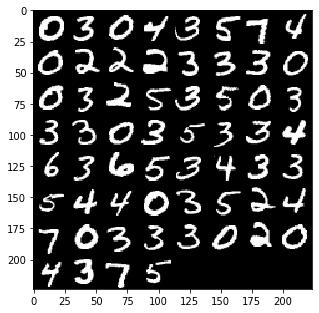

In [21]:
# Plot lowest total predictive uncertainty 
plot_uncertain_topk(total_entropy, 60, test_dataset, high_uncertainty=False)

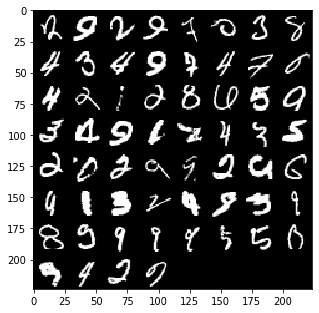

In [22]:
# Plot highest total predictive uncertainty 
plot_uncertain_topk(total_entropy, 60, test_dataset)

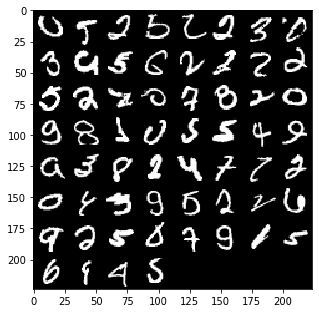

In [23]:
# Plot aleatoric uncertainty
plot_uncertain_topk(total_entropy - model_entropy, 60, test_dataset)

In [24]:
total_probs_np = total_probs.cpu().detach().numpy()
total_entropy_np = total_entropy.cpu().detach().numpy()
total_label_np = total_label.cpu().detach().numpy()

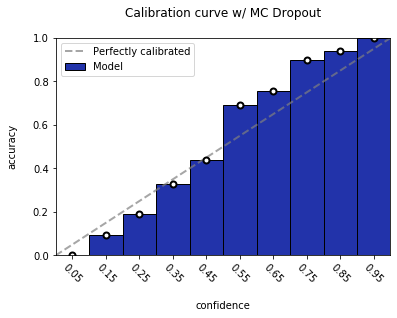

In [25]:
_ = plot_multiclass_calibration_curve(total_probs_np, total_label_np, bins=10, title='Calibration curve w/ MC Dropout')